# Final Project
# “Artificial Intelligence - Wind Power Generation Forecasting”

**Load libraries**

In [1]:
# Import all your libraries only in this cell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Make Num printout easier to read
np.set_printoptions(precision=3, suppress=True)

#tensorflow libarries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
from tensorboard.plugins.hparams import api as hp

**Load datasets**

In [4]:
# Connect to kaggle
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print("User uploaded file '{name}' with lenght {length} bytes".format(name=fn,
    length = len(uploaded[fn]) ))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file 'kaggle.json' with lenght 67 bytes


### connect google drive

In [5]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#load dataframes
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ai_dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ai_dataset/test.csv")

In [7]:
#show dataset
dataset = train_df.copy()
dataset.tail()

,ID,Date,Time,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3
25148,25149,12/31/2020,20:00,0.0,0.3,1.6
25149,25150,12/31/2020,21:00,0.0,0.0,1.2
25150,25151,12/31/2020,22:00,0.0,0.4,2.1
25151,25152,12/31/2020,23:00,0.0,0.0,2.2
25152,25153,12/31/2020,24:00:00,0.0,0.0,2.6


**Data cleaning**

In [8]:
dataset.isna().sum()

ID               0
Date             0
Time             0
Wind_Energy_1    0
Wind_Energy_2    0
Wind_Energy_3    0
dtype: int64

In [9]:
dataset = dataset.dropna()

### preprocess data

In [10]:
dataset['Month'] = dataset.Date.str.split('/').str[0].astype(float)
dataset['Days'] = dataset.Date.str.split('/').str[1].astype(float)
dataset['Hour'] = dataset.Time.str.split(':').str[0].astype(float)

In [11]:
dataset.drop(columns = ['Date', 'Time', 'ID'], inplace = True)
dataset.tail()

,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3,Month,Days,Hour
25148,0.0,0.3,1.6,12.0,31.0,20.0
25149,0.0,0.0,1.2,12.0,31.0,21.0
25150,0.0,0.4,2.1,12.0,31.0,22.0
25151,0.0,0.0,2.2,12.0,31.0,23.0
25152,0.0,0.0,2.6,12.0,31.0,24.0


In [12]:
## Split features
train_features = dataset.copy()

train_labels = train_features[['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3']].copy()
train_features = train_features.drop(['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
                                     axis = 1)

#### scaling

In [13]:
# scaling libraies
from sklearn.preprocessing import MinMaxScaler

In [14]:
ms = MinMaxScaler()
MinMaxScaled = ms.fit_transform(train_features)

In [15]:
print(MinMaxScaled)

[[0.091 0.533 1.   ]
 [0.091 0.567 0.   ]
 [0.091 0.567 0.043]
 ...
 [1.    1.    0.913]
 [1.    1.    0.957]
 [1.    1.    1.   ]]


##Linear regression with three variable

In [19]:
# libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.regularizers import l2
import keras.backend as k
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [20]:
#Deep learning model
three_var_model = Sequential()
#Fisrt layer
three_var_model.add(LSTM(50, input_shape=(3, 1)))
three_var_model.add(Dropout(0.3))
#hidden layer
three_var_model.add(Dense(64, activation = 'relu'))
three_var_model.add(Dropout(0.3))
three_var_model.add(Dense(64, activation = 'relu'))
three_var_model.add(Dropout(0.3))
#last layer
three_var_model.add(Dense(3, activation = 'linear'))
three_var_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [21]:
# compile
three_var_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.005),
    loss = 'mse',
    metrics = ['accuracy']
)

In [23]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

In [24]:
# run
%%time
history = three_var_model.fit(
   MinMaxScaled, #X 
   train_labels, #Y
   epochs = 100,
   batch_size = 200,
   #logging
   verbose = 1,
   # Calculate validation set based on training data
   validation_split = 0.2, # represent 20% of our training data
   callbacks = [es]
   
)

Epoch 1/100
101/101 [==============================] - 1s 14ms/step - loss: 137.1008 - accuracy: 0.5889 - val_loss: 166.7159 - val_accuracy: 0.5691
Epoch 2/100
101/101 [==============================] - 1s 12ms/step - loss: 138.5147 - accuracy: 0.5901 - val_loss: 164.7595 - val_accuracy: 0.5736
Epoch 3/100
101/101 [==============================] - 1s 11ms/step - loss: 136.8808 - accuracy: 0.5899 - val_loss: 165.8345 - val_accuracy: 0.5742
Epoch 4/100
101/101 [==============================] - 1s 8ms/step - loss: 136.7404 - accuracy: 0.5895 - val_loss: 165.6587 - val_accuracy: 0.5691
Epoch 5/100
101/101 [==============================] - 1s 8ms/step - loss: 136.9946 - accuracy: 0.5874 - val_loss: 163.7704 - val_accuracy: 0.5665
Epoch 6/100
101/101 [==============================] - 1s 8ms/step - loss: 137.7741 - accuracy: 0.5898 - val_loss: 161.7674 - val_accuracy: 0.5691
Epoch 7/100
101/101 [==============================] - 1s 8ms/step - loss: 136.9834 - accuracy: 0.5873 - val_loss: 

----------------------------------

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
30,135.188110,0.592585,165.079895,0.565891,30
31,135.107452,0.593032,163.193039,0.566488,31
32,135.078415,0.594921,167.181488,0.571059,32
33,134.831543,0.592933,167.538132,0.573445,33
34,136.154541,0.592436,163.714554,0.569271,34


In [26]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [kwh]')
  plt.legend()
  plt.grid(True)

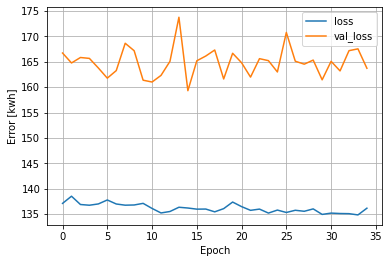

In [27]:
plot_loss(history)

In [28]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label = 'accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Error [kwh]')
  plt.legend()
  plt.grid(True)

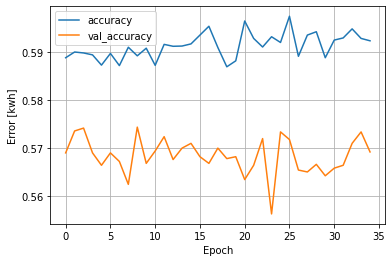

In [29]:
plot_accuracy(history)

In [30]:
test_df['Month'] = test_df.Date.str.split('/').str[0].astype(float)
test_df['Days'] = test_df.Date.str.split('/').str[1].astype(float)
test_df['Hour'] = test_df.Time.str.split(':').str[0].astype(float)
test_df.drop(columns = ['Date','Time'])
test_df.tail()

,ID,Date,Time,Month,Days,Hour
6979,32133,10/18/2021,20:00,10.0,18.0,20.0
6980,32134,10/18/2021,21:00,10.0,18.0,21.0
6981,32135,10/18/2021,22:00,10.0,18.0,22.0
6982,32136,10/18/2021,23:00,10.0,18.0,23.0
6983,32137,10/18/2021,24:00:00,10.0,18.0,24.0


In [31]:
test_df.tail()

,ID,Date,Time,Month,Days,Hour
6979,32133,10/18/2021,20:00,10.0,18.0,20.0
6980,32134,10/18/2021,21:00,10.0,18.0,21.0
6981,32135,10/18/2021,22:00,10.0,18.0,22.0
6982,32136,10/18/2021,23:00,10.0,18.0,23.0
6983,32137,10/18/2021,24:00:00,10.0,18.0,24.0


In [34]:
test_features = test_df[['Month', 'Days', 'Hour']]

In [35]:
def MinMax(data):
  return (data - 1) / (12 - 1)

In [37]:
test_month = test_features['Month'].apply(MinMax)
test_features['Month'] = test_month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
test_scaled = pd.DataFrame(ms.fit_transform(test_features[['Days', 'Hour']]))

In [40]:
test_features[['Days', 'Hour']] = test_scaled

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [41]:
DNN_three_df = three_var_model.predict(test_features[['Month','Days','Hour']])

In [42]:
DNN_three_df

array([[25.167, 14.385, 15.814],
       [25.053, 14.452, 15.873],
       [24.912, 14.443, 15.893],
       ...,
       [ 8.128,  5.732,  5.826],
       [ 8.695,  6.731,  6.393],
       [ 8.811,  7.383,  6.293]], dtype=float32)

In [43]:
result = pd.DataFrame(DNN_three_df,
                      columns = ['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
                      index = test_df['ID'])
result.to_csv('/content/drive/MyDrive/Colab Notebooks/ai_dataset/100.csv')

In [ ]:
## To automatically upload thr file using Kaggle ApI
result.to_csv('dnn_three_input.csv')
!kaggle competitions submit -c aifpc2022 -f dnn_three_input.csv -m "Three inputs"

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "DL model three input" \
  --description "Training result" \
  --one_shot